## Add your secret:

1. Click the key icon in the left hand menu
2. Click the **'Add new secret'**
3. Enter in your secret and make sure to **toggle 'Notebook Access'**

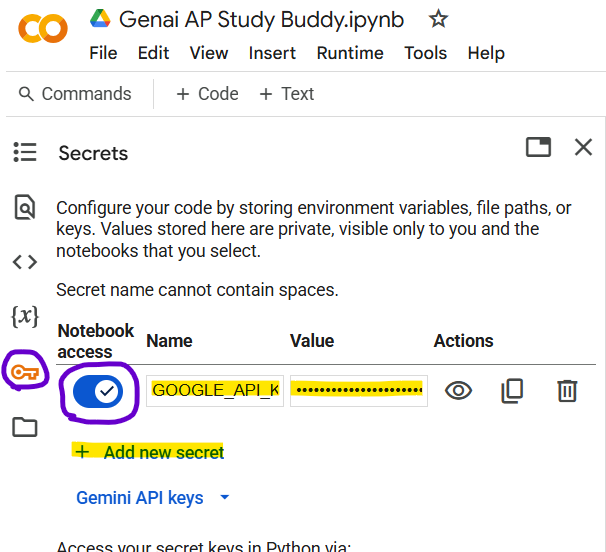


In [ ]:
# Get Google API Key
from google.colab import userdata
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY") # Change to your API Key

### To Run the code :
Select Runtime dropdown menu and click **'Run all'**

**NOTE**: You will need to provide a **GOOGLE_API_KEY**

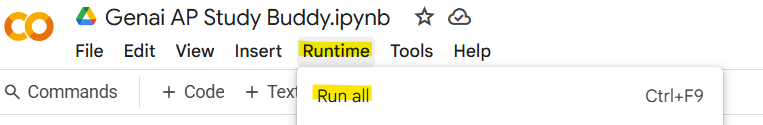

### To See the App:
Go to Table of Contents and click **'App Run'**


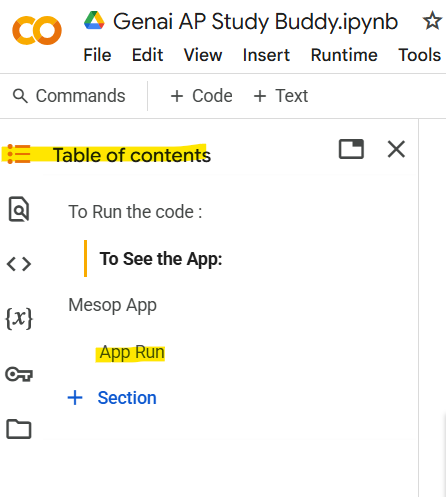

In [ ]:
!pip uninstall -qyy jupyterlab kfp jupyterlab-lsp
!pip install -qU "google-genai==1.9.0" "chromadb==0.6.3"
!pip install -qU mesop

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.8 MB/s eta 0:0

In [ ]:
# Get AP Exam Files
!wget -O ap_stats_questions.pdf https://apcentral.collegeboard.org/media/pdf/ap24-frq-statistics.pdf

--2025-04-20 18:32:38--  https://apcentral.collegeboard.org/media/pdf/ap24-frq-statistics.pdf
Resolving apcentral.collegeboard.org (apcentral.collegeboard.org)... 104.18.27.195, 104.18.26.195, 2606:4700::6812:1ac3, ...
Connecting to apcentral.collegeboard.org (apcentral.collegeboard.org)|104.18.27.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3244567 (3.1M) [application/pdf]
Saving to: ‘ap_stats_questions.pdf’

ap_stats_questions. 100%[===================>]   3.09M  --.-KB/s    in 0.08s   

2025-04-20 18:32:38 (41.1 MB/s) - ‘ap_stats_questions.pdf’ saved [3244567/3244567]



In [ ]:
# Standard Library
import numpy as np
import pandas as pd
from collections.abc import Iterable
from pprint import pprint
from random import randint
import random
import time
from typing import Annotated, Literal, Callable
from typing_extensions import TypedDict
import base64

# Third-Party Libraries
import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings
from IPython.display import Markdown, HTML, display, Image
from google.api_core import retry
from google import genai
from google.genai import types
import PIL.Image
import mesop as me
import mesop.labs as mel

In [ ]:
# Instantiate Gemini LLM API
client = genai.Client(api_key=GOOGLE_API_KEY)

In [ ]:
me.colab_run()


Running server on: http://localhost:32123
 * Serving Flask app 'mesop.server.server'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (::)
 * Running on http://[::1]:32123
 * Running on http://[::1]:32123


In [ ]:
# Prompt 1: Generate AP Statistics Test Questions
prompt1_topic_choices = [
    "Exploring One-Variable Data",
    "Exploring Two-Variable Data",
    "Collecting Data",
    "Probability, Random Variables, and Probability Distributions",
    "Sampling Distributions",
    "Inference for Categorical Data: Proportions",
    "Inference for Quantitative Data: Means",
    "Inference for Categorical Data: Chi-Square",
    "Inference for Quantitative Data: Slopes"
] # Taken from actual AP Test design here https://apcentral.collegeboard.org/media/pdf/ap-statistics-course-overview.pdf

prompt1_types = [ 'multiple-choice' , 'free-response']

PROMPT_1 = '''
You are an AP Statistics Exam Creator.
You will generate one AP Statistics {prompt1_type} test question covering the topic of {prompt1_specific_topic}.
Ensure the questions are similar in style, complexity, and phrasing to those found on the official College Board AP Statistics exam.
Only provide the question itself and a suggested time to complete it in.
Await the user to follow-up before providing the correct answer and a brief explanation of the reasoning behind the correct answer.
'''


# Prompt 2: Explain AP Statistics Test Questions from Scratch

PROMPT_2 = '''
You are an AP Statistics Exam Expert.
Please explain the following AP Statistics test question from scratch. Assume I need a fundamental understanding. Break down:
a) The core statistical concept(s) being tested.
b) The necessary conditions or assumptions, if any.
c) The step-by-step process required to arrive at the correct solution, including any relevant formulas or calculator procedures (mentioning general steps, e.g., "use the t-test function").
d) How to interpret the result in the context of the problem.
e) Why the incorrect answer choices (if applicable) are wrong.

The question is in the PDF attached:'''


# Prompt 3: Guide Student's AP Statistics FRQ work
PROMPT_3 = '''
You are an AP Statistics Exam Expert Tutor.
Your goal is to guide a student through completing an AP Statistics Free Response Question (FRQ) based on their current work (which will be described from a screenshot).
You need to help them identify correct steps, gently correct misunderstandings, and lead them towards a full solution, highlighting typical scoring milestones on the AP 0-4 scale.

**Your Response Structure:**
Follow the sequence: Thought, Action, Observation for each step of guidance.

* **Thought:** Your internal reasoning process. Analyze the provided description of the student's work for a specific part of the FRQ (e.g., stating hypotheses, checking conditions, performing calculations, writing the conclusion). Identify what the student has done correctly and what is missing or incorrect. Plan the next *guiding* step. Consider how this step relates to the typical 0-4 scoring rubric (e.g., "Checking conditions is crucial for getting past 1 point," "Correct mechanics build towards 3 points," "Context in the conclusion is needed for 4 points").
* **Action:** The **guidance you provide directly TO THE STUDENT**. This MUST be encouraging and constructive. Acknowledge correct work first. If something is missing or wrong, ask guiding questions or provide hints rather than just stating the error or the answer. Explicitly reference the scoring milestones when appropriate. For example:
    * "Getting these conditions checked correctly often helps secure **2 points** on the rubric."
    * "Nice work on the calculation! That accuracy, combined with the setup, really moves you towards the **3-point** mark."
    * "To potentially earn the full **4 points**, remember to link your conclusion back to the context of the problem and your hypotheses."
    * Use the action `<finish>Guidance Complete</finish>` only when you have guided the student through all necessary parts of the question and offered final feedback. *Do not* use search or lookup actions unless specifically relevant to explaining a concept the student is stuck on and you state that in your Thought.
* **Observation:** Your reflection *after* delivering the Action. Briefly state what guidance was given and what the student is expected to think about or do next. Assess the student's likely position in the problem-solving process and relation to the scoring scale after processing the Action.

**AP FRQ Scoring (0-4 Scale) Milestones to Mention:**
* **Reaching ~2 points:** Often achieved by getting the initial setup (parameter/hypothesis/procedure) essentially correct AND making significant progress on checking necessary conditions/assumptions.
* **Reaching ~3 points:** Typically requires correct setup AND conditions/assumptions, PLUS largely correct calculations/mechanics. There might be a minor error, or the conclusion might lack full context/linkage.
* **Reaching 4 points (Full Credit):** All components (Setup/State, Conditions/Plan, Mechanics/Do, Conclusion **in context**) are essentially correct and well-communicated.

**To start, I need:**
1.  **The full text of the AP Statistics FRQ.**
2.  **A detailed description of the student's work/solution attempt as seen in the screenshot.**

**Example Interaction Start (Illustrative - adapt based on actual student work):**

**(User provides: Question about comparing two means. Description: Student wrote correct hypotheses for H₀: μ₁=μ₂, Hₐ: μ₁≠μ₂, identified it as a 2-sample t-test, but listed only "Random Samples" under conditions.)**

Thought 1: The student correctly identified the parameters, hypotheses (two-tailed), and the appropriate procedure (2-sample t-test). This is a good start, likely covering the 'State' component. However, for the 'Plan' component (conditions), they only listed 'Random Samples'. They are missing the checks for independence (e.g., 10% condition) and normality (e.g., sample size ≥ 30 or graphs). Addressing these conditions correctly is crucial for scoring above a 1 or potentially reaching the **2-point** threshold. I need to prompt them to think about the *other* conditions needed for a two-sample t-test.
Action 1: Excellent job stating the hypotheses correctly and identifying the two-sample t-test! That's the perfect start. You've also correctly noted the need for random samples. For this type of test, there are usually two other key conditions or assumptions we need to check to ensure our results are valid. Can you think of what those might be? Getting all the conditions checked properly is a big step towards securing potentially **2 points** or more.
Observation 1: I've affirmed the student's correct initial steps (hypotheses, procedure) and acknowledged their partial work on conditions. I prompted them to recall the remaining conditions (independence/10% and normality) without giving them away directly. This guides them to complete the 'Plan' stage, which is necessary for higher scores. The next step depends on how they respond regarding the missing conditions.


'''

INFO:werkzeug:Press CTRL+C to quit


## Mesop App

In [ ]:
import random
import time
from dataclasses import asdict, dataclass
from typing import Callable, Literal

import mesop as me

Role = Literal["user", "bot"]


_APP_TITLE = "AP Test Study Buddy"
_BOT_AVATAR_LETTER = "Bud"
_EMPTY_CHAT_MESSAGE = "Get started with an example"
_EXAMPLE_USER_QUERIES = (
  "Generate an AP Statistics Practice Question",
  "Explain this AP Statistics test question ...",
  "Guide me through the work I have done so far ...",
)
_CHAT_MAX_WIDTH = "800px"
_MOBILE_BREAKPOINT = 640
_TEMPERATURE_MIN = 0.0
_TEMPERATURE_MAX = 2.0
_TOKEN_LIMIT_MIN = 1
_TOKEN_LIMIT_MAX = 8192

# Styles
_DEFAULT_BORDER = me.Border.all(
  me.BorderSide(color=me.theme_var("outline-variant"), width=1, style="solid")
)
_STYLE_INPUT_WIDTH = me.Style(width="100%")
_STYLE_SLIDER_INPUT_BOX = me.Style(display="flex", flex_wrap="wrap")
_STYLE_SLIDER_WRAP = me.Style(flex_grow=1)
_STYLE_SLIDER_LABEL = me.Style(padding=me.Padding(bottom=10))
_STYLE_SLIDER = me.Style(width="90%")
_STYLE_SLIDER_INPUT = me.Style(width=75)

_STYLE_STOP_SEQUENCE_BOX = me.Style(display="flex")
_STYLE_STOP_SEQUENCE_WRAP = me.Style(flex_grow=1)

_STYLE_CONFIG_COLUMN = me.Style(
  border=_DEFAULT_BORDER,
  padding=me.Padding.all(15),
  overflow_y="scroll",
)



@dataclass(kw_only=True)
class ChatMessage:
  """Chat message metadata."""
  role: Role = "user"
  content: str = ""
  edited: bool = False
  # 1 is positive
  # -1 is negative
  # 0 is no rating
  rating: int = 0


@me.stateclass
class State:
  input: str
  output: list[ChatMessage]
  in_progress: bool
  sidebar_expanded: bool = False
  file: me.UploadedFile
  # Need to use dict instead of ChatMessage due to serialization bug.
  # See: https://github.com/mesop-dev/mesop/issues/659
  history: list[list[dict]]

  # Model configs
  selected_model: str = "models/gemini-2.0-flash"
  selected_region: str = "us-east4"
  temperature: float = 1.0
  temperature_for_input: float = 1.0
  token_limit: int = _TOKEN_LIMIT_MAX
  token_limit_for_input: int = _TOKEN_LIMIT_MAX


def respond_to_chat(input: str, history: list[ChatMessage]):
  """Displays random canned text.

  Edit this function to process messages with a real chatbot/LLM.
  """
  state = me.state(State)

  # Instantiate Gemini with retries for endpoint connection failures
  from google.api_core import retry

  is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

  if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
    genai.models.Models.generate_content = retry.Retry(
        predicate=is_retriable)(genai.models.Models.generate_content)

  config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=state.temperature_for_input, # Temperature 0.2 used based on Prompt Engineering white paper (https://www.kaggle.com/whitepaper-prompt-engineering)
     max_output_tokens=state.token_limit_for_input,
)
  def query_with_grounding(prompt: list):
    response = client.models.generate_content(
        model= 'models/gemini-2.0-flash', #'models/gemini-2.5-flash-preview-04-17', # models/gemini-2.5-pro-exp-03-25
        contents=prompt,
        config=config_with_search,
    )
    return response.candidates[0]

  if 'Practice' in input:
    completed_prompt1 = PROMPT_1.format(
    prompt1_type= np.random.choice(prompt1_types ),
    prompt1_specific_topic=np.random.choice(prompt1_topic_choices )
)
    rc = query_with_grounding([completed_prompt1])

  elif 'Explain' in input:
    # Explain AP Statistics Test Questions from Scratch
    test_question_fp = "ap_stats_questions.pdf"
    test_question_pdf = client.files.upload(file=test_question_fp) # Load Sample question
    rc = query_with_grounding([PROMPT_2, test_question_pdf])

  elif 'Guide' in input:
    # Prompt 3: Guide Student's AP Statistics FRQ work
    test_question_fp = "/content/drive/MyDrive/Google AI Studio/IMG_3657.jpeg"
    test_question_img = PIL.Image.open(test_question_fp)

    student_response_fp = "/content/drive/MyDrive/Google AI Studio/IMG_3658.jpeg"
    student_response_img = PIL.Image.open(student_response_fp)

    rc = query_with_grounding([PROMPT_3, test_question_img,student_response_img ])

  else:
    if state.file:
      uploaded_file = client.files.upload(file=state.file)
      rc = query_with_grounding([input , uploaded_file ])
    else:
      rc = query_with_grounding([input ])

  for part in rc.content.parts:
    time.sleep(0.3)
    yield part.text + " "


def on_load(e: me.LoadEvent):
  me.set_theme_mode("system")


@me.page(
  security_policy=me.SecurityPolicy(
    allowed_iframe_parents=["https://mesop-dev.github.io"]
  ),
  title="AP Study Buddy",
  path="/AP_Study_Buddy",
  on_load=on_load,
)
def page():
  state = me.state(State)

  with me.box(
    style=me.Style(
      background=me.theme_var("surface-container-lowest"),
      display="flex",
      flex_direction="column",
      height="100%",
    )
  ):
    with me.box(
      style=me.Style(
        display="flex", flex_direction="row", flex_grow=1, overflow="hidden"
      )
    ):
      with me.box(
        style=me.Style(
          background=me.theme_var("surface-container-low"),
          display="flex",
          flex_direction="column",
          flex_shrink=0,
          position="absolute"
          if state.sidebar_expanded and _is_mobile()
          else None,
          height="100%" if state.sidebar_expanded and _is_mobile() else None,
          width=300 if state.sidebar_expanded else None,
          z_index=2000,
        )
      ):
        sidebar()

      with me.box(
        style=me.Style(
          display="flex",
          flex_direction="column",
          flex_grow=1,
          padding=me.Padding(left=60)
          if state.sidebar_expanded and _is_mobile()
          else None,
        )
      ):
        header()
        with me.box(style=me.Style(flex_grow=1, overflow_y="scroll")):
          if state.output:
            chat_pane()
          else:
            examples_pane()
        chat_input()


def sidebar():
  state = me.state(State)
  with me.box(
    style=me.Style(
      display="flex",
      flex_direction="column",
      flex_grow=1,
    )
  ):
    with me.box(style=me.Style(display="flex", gap=20)):
      menu_icon(icon="menu", tooltip="Menu", on_click=on_click_menu_icon)
      if state.sidebar_expanded:
        me.text(
          _APP_TITLE,
          style=me.Style(margin=me.Margin(bottom=0, top=14)),
          type="headline-6",
        )

    if state.sidebar_expanded:
      menu_item(icon="add", label="New chat", on_click=on_click_new_chat)
    else:
      menu_icon(icon="add", tooltip="New chat", on_click=on_click_new_chat)

    if state.sidebar_expanded:
      history_pane()

  # LLM Config
  with me.box(style=_STYLE_CONFIG_COLUMN):
    me.select(
      options=[
        me.SelectOption(label="Gemini 2.0 Flash", value="models/gemini-2.0-flash"),
        me.SelectOption(label="Gemini 2.5 Flash", value="models/gemini-2.5-flash-preview-04-17"),
        me.SelectOption(label="Gemini 2.5 Thinking", value="models/gemini-2.5-pro-exp-03-25"),
        me.SelectOption(label="Gemma 3 27b", value="models/gemma-3-27b-it"),
      ],
      label="Model",
      style=_STYLE_INPUT_WIDTH,
      on_selection_change=on_model_select,
      value=state.selected_model,
    )

  me.text("Temperature", style=_STYLE_SLIDER_LABEL)
  with me.box(style=_STYLE_SLIDER_INPUT_BOX):
    with me.box(style=_STYLE_SLIDER_WRAP):
      me.slider(
        min=_TEMPERATURE_MIN,
        max=_TEMPERATURE_MAX,
        step=0.1,
        style=_STYLE_SLIDER,
        on_value_change=on_slider_temperature,
        value=state.temperature,
      )
    me.input(
      style=_STYLE_SLIDER_INPUT,
      value=str(state.temperature_for_input),
      on_input=on_input_temperature,
    )

  me.text("Output Token Limit", style=_STYLE_SLIDER_LABEL)
  with me.box(style=_STYLE_SLIDER_INPUT_BOX):
    with me.box(style=_STYLE_SLIDER_WRAP):
      me.slider(
        min=_TOKEN_LIMIT_MIN,
        max=_TOKEN_LIMIT_MAX,
        style=_STYLE_SLIDER,
        on_value_change=on_slider_token_limit,
        value=state.token_limit,
      )
    me.input(
      style=_STYLE_SLIDER_INPUT,
      value=str(state.token_limit_for_input),
      on_input=on_input_token_limit,
    )


def history_pane():
  state = me.state(State)
  for index, chat in enumerate(state.history):
    with me.box(
      key=f"chat-{index}",
      on_click=on_click_history,
      style=me.Style(
        background=me.theme_var("surface-container"),
        border=me.Border.all(
          me.BorderSide(
            width=1, color=me.theme_var("outline-variant"), style="solid"
          )
        ),
        border_radius=5,
        cursor="pointer",
        margin=me.Margin.symmetric(horizontal=10, vertical=10),
        padding=me.Padding.all(10),
        text_overflow="ellipsis",
      ),
    ):
      me.text(_truncate_text(chat[0]["content"]))


def header():
  state = me.state(State)
  with me.box(
    style=me.Style(
      align_items="center",
      background=me.theme_var("surface-container-lowest"),
      display="flex",
      gap=5,
      justify_content="space-between",
      padding=me.Padding.symmetric(horizontal=20, vertical=10),
    )
  ):
    with me.box(style=me.Style(display="flex", gap=5)):
      if not state.sidebar_expanded:
        me.text(
          _APP_TITLE,
          style=me.Style(margin=me.Margin(bottom=0)),
          type="headline-6",
        )

    with me.box(style=me.Style(display="flex", gap=5)):
      icon_button(
        key="",
        icon="dark_mode" if me.theme_brightness() == "light" else "light_mode",
        tooltip="Dark mode"
        if me.theme_brightness() == "light"
        else "Light mode",
        on_click=on_click_theme_brightness,
      )


def examples_pane():
  with me.box(
    style=me.Style(
      margin=me.Margin.symmetric(horizontal="auto"),
      padding=me.Padding.all(15),
      width=f"min({_CHAT_MAX_WIDTH}, 100%)",
    )
  ):
    with me.box(style=me.Style(margin=me.Margin(top=25), font_size=24)):
      me.text(_EMPTY_CHAT_MESSAGE)

    with me.box(
      style=me.Style(
        display="flex",
        flex_direction="column" if _is_mobile() else "row",
        gap=20,
        margin=me.Margin(top=25),
      )
    ):
      for index, query in enumerate(_EXAMPLE_USER_QUERIES):
        with me.box(
          key=f"query-{index}",
          on_click=on_click_example_user_query,
          style=me.Style(
            background=me.theme_var("surface-container-highest"),
            border_radius=15,
            padding=me.Padding.all(20),
            cursor="pointer",
          ),
        ):
          me.text(query)


def chat_pane():
  state = me.state(State)
  with me.box(
    style=me.Style(
      background=me.theme_var("surface-container-lowest"),
      color=me.theme_var("on-surface"),
      display="flex",
      flex_direction="column",
      margin=me.Margin.symmetric(horizontal="auto"),
      padding=me.Padding.all(15),
      width=f"min({_CHAT_MAX_WIDTH}, 100%)",
    )
  ):
    for index, msg in enumerate(state.output):
      if msg.role == "user":
        user_message(message=msg)
      else:
        bot_message(message_index=index, message=msg)

    if state.in_progress:
      with me.box(key="scroll-to", style=me.Style(height=250)):
        pass


def user_message(*, message: ChatMessage):
  with me.box(
    style=me.Style(
      display="flex",
      gap=15,
      justify_content="end",
      margin=me.Margin.all(20),
    )
  ):
    with me.box(
      style=me.Style(
        background=me.theme_var("surface-container-low"),
        border_radius=10,
        color=me.theme_var("on-surface-variant"),
        padding=me.Padding.symmetric(vertical=0, horizontal=10),
        width="66%",
      )
    ):
      me.markdown(message.content)


def bot_message(*, message_index: int, message: ChatMessage):
  with me.box(style=me.Style(display="flex", gap=15, margin=me.Margin.all(20))):
    text_avatar(
      background=me.theme_var("primary"),
      color=me.theme_var("on-primary"),
      label=_BOT_AVATAR_LETTER,
    )

    # Bot message response
    with me.box(style=me.Style(display="flex", flex_direction="column")):
      me.markdown(
        message.content,
        style=me.Style(color=me.theme_var("on-surface")),
      )

      # Actions panel
      with me.box():
        icon_button(
          key=f"thumb_up-{message_index}",
          icon="thumb_up",
          is_selected=message.rating == 1,
          tooltip="Good response",
          on_click=on_click_thumb_up,
        )
        icon_button(
          key=f"thumb_down-{message_index}",
          icon="thumb_down",
          is_selected=message.rating == -1,
          tooltip="Bad response",
          on_click=on_click_thumb_down,
        )
        icon_button(
          key=f"restart-{message_index}",
          icon="restart_alt",
          tooltip="Regenerate answer",
          on_click=on_click_regenerate,
        )


def chat_input():
  state = me.state(State)
  with me.box(
    style=me.Style(
      background=me.theme_var("surface-container")
      if _is_mobile()
      else me.theme_var("surface-container"),
      border_radius=16,
      display="flex",
      margin=me.Margin.symmetric(horizontal="auto", vertical=15),
      padding=me.Padding.all(8),
      width=f"min({_CHAT_MAX_WIDTH}, 90%)",
    )
  ):
    with me.box(
      style=me.Style(
        flex_grow=1,
      )
    ):
      me.native_textarea(
        autosize=True,
        key="chat_input",
        min_rows=4,
        on_blur=on_chat_input,
        shortcuts={
          me.Shortcut(shift=True, key="Enter"): on_submit_chat_msg,
        },
        placeholder="Enter your prompt",
        style=me.Style(
          background=me.theme_var("surface-container")
          if _is_mobile()
          else me.theme_var("surface-container"),
          border=me.Border.all(
            me.BorderSide(style="none"),
          ),
          color=me.theme_var("on-surface-variant"),
          outline="none",
          overflow_y="auto",
          padding=me.Padding(top=16, left=16),
          width="100%",
        ),
        value=state.input,
      )

    # with me.content_button(type="icon"):
    #   me.icon("upload")
    # with me.content_uploader(
    #     accepted_file_types=["image/jpeg", "image/png"],
    #     on_upload=handle_upload,
    #     type="flat",
    #     color="warn",
    #     multiple=True,
    #     style=me.Style(font_weight="bold"),
    #   ):
    #     me.icon("upload")

    with me.content_uploader(
    accepted_file_types=["image/jpeg", "image/png"],
    on_upload=handle_upload,
    type="flat",
    color="warn",
    style=me.Style(font_weight="bold"),
  ):
      me.icon("upload")

    with me.content_button(
      disabled=state.in_progress,
      on_click=on_click_submit_chat_msg,
      type="icon",
    ):
      me.icon("send")

    if state.file.size:
      with me.box(style=me.Style(margin=me.Margin.all(10))):
        me.text(f"File name: {state.file.name}")
        me.text(f"File size: {state.file.size}")
        me.text(f"File type: {state.file.mime_type}")

      with me.box(style=me.Style(margin=me.Margin.all(10))):
        me.image(src=_convert_contents_data_url(state.file),
                style=  me.Style(
        max_width="30px",  # Set maximum width (e.g., 300 pixels)
        height="auto",     # Ensures the height adjusts proportionally
        display="block"    # Often helpful to treat image as a block element
      )
                #  style=me.Style(width="10%")
                 )


@me.component
def text_avatar(*, label: str, background: str, color: str):
  me.text(
    label,
    style=me.Style(
      background=background,
      border_radius="50%",
      color=color,
      font_size=20,
      height=40,
      line_height="1",
      margin=me.Margin(top=16),
      padding=me.Padding(top=10),
      text_align="center",
      width="40px",
    ),
  )


@me.component
def icon_button(
  *,
  icon: str,
  tooltip: str,
  key: str = "",
  is_selected: bool = False,
  on_click: Callable | None = None,
):
  selected_style = me.Style(
    background=me.theme_var("surface-container-low"),
    color=me.theme_var("on-surface-variant"),
  )
  with me.tooltip(message=tooltip):
    with me.content_button(
      type="icon",
      key=key,
      on_click=on_click,
      style=selected_style if is_selected else None,
    ):
      me.icon(icon)


@me.component
def menu_icon(
  *, icon: str, tooltip: str, key: str = "", on_click: Callable | None = None
):
  with me.tooltip(message=tooltip):
    with me.content_button(
      key=key,
      on_click=on_click,
      style=me.Style(margin=me.Margin.all(10)),
      type="icon",
    ):
      me.icon(icon)


@me.component
def menu_item(
  *, icon: str, label: str, key: str = "", on_click: Callable | None = None
):
  with me.box(on_click=on_click):
    with me.box(
      style=me.Style(
        background=me.theme_var("surface-container-high"),
        border_radius=20,
        cursor="pointer",
        display="inline-flex",
        gap=10,
        line_height=1,
        margin=me.Margin.all(10),
        padding=me.Padding(top=10, left=10, right=20, bottom=10),
      ),
    ):
      me.icon(icon)
      me.text(label, style=me.Style(height=24, line_height="24px"))


# Event Handlers


def on_click_example_user_query(e: me.ClickEvent):
  """Populates the user input with the example query"""
  state = me.state(State)
  _, example_index = e.key.split("-")
  state.input = _EXAMPLE_USER_QUERIES[int(example_index)]
  me.focus_component(key="chat_input")


def on_click_thumb_up(e: me.ClickEvent):
  """Gives the message a positive rating"""
  state = me.state(State)
  _, msg_index = e.key.split("-")
  msg_index = int(msg_index)
  state.output[msg_index].rating = 1


def on_click_thumb_down(e: me.ClickEvent):
  """Gives the message a negative rating"""
  state = me.state(State)
  _, msg_index = e.key.split("-")
  msg_index = int(msg_index)
  state.output[msg_index].rating = -1


def on_click_new_chat(e: me.ClickEvent):
  """Resets messages."""
  state = me.state(State)
  if state.output:
    state.history.insert(0, [asdict(messages) for messages in state.output])
  state.output = []
  me.focus_component(key="chat_input")


def on_click_history(e: me.ClickEvent):
  """Loads existing chat from history and saves current chat"""
  state = me.state(State)
  _, chat_index = e.key.split("-")
  chat_messages = [
    ChatMessage(**chat) for chat in state.history.pop(int(chat_index))
  ]
  if state.output:
    state.history.insert(0, [asdict(messages) for messages in state.output])
  state.output = chat_messages
  me.focus_component(key="chat_input")


def on_click_theme_brightness(e: me.ClickEvent):
  """Toggles dark mode."""
  if me.theme_brightness() == "light":
    me.set_theme_mode("dark")
  else:
    me.set_theme_mode("light")


def on_click_menu_icon(e: me.ClickEvent):
  """Expands and collapses sidebar menu."""
  state = me.state(State)
  state.sidebar_expanded = not state.sidebar_expanded


def on_chat_input(e: me.InputBlurEvent):
  """Capture chat text input on blur."""
  state = me.state(State)
  state.input = e.value


def on_click_regenerate(e: me.ClickEvent):
  """Regenerates response from an existing message"""
  state = me.state(State)
  _, msg_index = e.key.split("-")
  msg_index = int(msg_index)

  # Get the user message which is the previous message
  user_message = state.output[msg_index - 1]
  # Get bot message to be regenerated
  assistant_message = state.output[msg_index]
  assistant_message.content = ""
  state.in_progress = True
  yield

  start_time = time.time()
  # Send in the old user input and chat history to get the bot response.
  # We make sure to only pass in the chat history up to this message.
  output_message = respond_to_chat(
    user_message.content, state.output[:msg_index]
  )
  for content in output_message:
    assistant_message.content += content
    # TODO: 0.25 is an abitrary choice. In the future, consider making this adjustable.
    if (time.time() - start_time) >= 0.25:
      start_time = time.time()
      yield

  state.in_progress = False
  me.focus_component(key="chat_input")
  yield


def on_submit_chat_msg(e: me.TextareaShortcutEvent):
  state = me.state(State)
  state.input = e.value
  yield
  yield from _submit_chat_msg()


def on_click_submit_chat_msg(e: me.ClickEvent):
  yield from _submit_chat_msg()


def _submit_chat_msg():
  """Handles submitting a chat message."""
  state = me.state(State)
  if state.in_progress or not state.input:
    return
  input = state.input
  # Clear the text input.
  state.input = ""
  yield

  output = state.output
  if output is None:
    output = []
  output.append(ChatMessage(role="user", content=input))
  state.in_progress = True
  me.scroll_into_view(key="scroll-to")
  yield

  start_time = time.time()
  # Send user input and chat history to get the bot response.
  output_message = respond_to_chat(input, state.output)
  assistant_message = ChatMessage(role="bot")
  output.append(assistant_message)
  state.output = output
  for content in output_message:
    assistant_message.content += content
    # TODO: 0.25 is an abitrary choice. In the future, consider making this adjustable.
    if (time.time() - start_time) >= 0.25:
      start_time = time.time()
      yield

  state.in_progress = False
  me.focus_component(key="chat_input")
  yield


# Helpers


def _is_mobile():
  return me.viewport_size().width < _MOBILE_BREAKPOINT


def _truncate_text(text, char_limit=100):
  """Truncates text that is too long."""
  if len(text) <= char_limit:
    return text
  truncated_text = text[:char_limit].rsplit(" ", 1)[0]
  return truncated_text.rstrip(".,!?;:") + "..."

def handle_upload(event: me.UploadEvent):
  state = me.state(State)
  state.file = event.file


def _convert_contents_data_url(file: me.UploadedFile) -> str:
  return (
    f"data:{file.mime_type};base64,{base64.b64encode(file.getvalue()).decode()}"
  )

def on_slider_temperature(e: me.SliderValueChangeEvent):
  """Event to adjust temperature slider value."""
  state = me.state(State)
  state.temperature = float(e.value)
  state.temperature_for_input = state.temperature


def on_input_temperature(e: me.InputEvent):
  """Event to adjust temperature slider value by input."""
  state = me.state(State)
  try:
    temperature = float(e.value)
    if _TEMPERATURE_MIN <= temperature <= _TEMPERATURE_MAX:
      state.temperature = temperature
  except ValueError:
    pass


def on_slider_token_limit(e: me.SliderValueChangeEvent):
  """Event to adjust token limit slider value."""
  state = me.state(State)
  state.token_limit = int(e.value)
  state.token_limit_for_input = state.token_limit


def on_input_token_limit(e: me.InputEvent):
  """Event to adjust token limit slider value by input."""
  state = me.state(State)
  try:
    token_limit = int(e.value)
    if _TOKEN_LIMIT_MIN <= token_limit <= _TOKEN_LIMIT_MAX:
      state.token_limit = token_limit
  except ValueError:
    pass

def on_model_select(e: me.SelectSelectionChangeEvent):
  """Event to select model."""
  state = me.state(State)
  state.selected_model = e.value

### App Run

In [ ]:
me.colab_show(path="/AP_Study_Buddy", height=500)

<IPython.core.display.Javascript object>